# Fraud Detection

## Problem

Given our times, many people use electronic means to pay for and cover expenses. This builds a trust in online security and leads to consumers not checking their bank accounts as much as they should. As such, it becomes very easy for many to commit malicious actions such as fraud. In light of this, it is imperative that we create a method that determines whether a purchase is fraud or not with a high accuracy.

Given the circumstance of the variable we are looking for, isFraud, and the knowledge that mislabeling something as fraud is significally less harmful than mislabeling something as notfruad; it is evident that we should base our metrics on recall rather than accuracy.

## Data Collection and Overview

### Importing Necessary Libraries

In [1]:
# data mutation
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# setting train and test variables
from sklearn.model_selection import train_test_split

# machine learning algorithms tested
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# guiding metrics and validation checking
from sklearn.metrics import roc_auc_score as ras, recall_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

### Importing Data

In [2]:
data = pd.read_csv('PS_20174392719_1491204439457_log.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


**Variables Descriptions**
- step: represents a unit of time where 1 step equals 1 hour
- type: type of online transaction
- amount: the amount of the transaction
- nameOrig: customer starting the transaction
- oldbalanceOrg: balance before the transaction
- newbalanceOrig: balance after the transaction
- nameDest: recipient of the transaction
- oldbalanceDest: initial balance of recipient before the transaction
- newbalanceDest: the new balance of recipient after the transaction
- isFraud: fraud transaction
- isFlaggedFraud: wether it was marked fraud by its previous algorithm

In [3]:
print('There were {} entries that were correctly labels as fraud'.format(len(data[(data['isFlaggedFraud'] == 1) & (data['isFraud'] == 1)])))
print('There were {} entries that were fraud and not labed as not fraud'.format(len(data[(data['isFlaggedFraud'] == 0) & (data['isFraud'] == 1)])))
print('There were {} entries that were labeld as fraud and were not fraud'.format(len(data[(data['isFlaggedFraud'] == 1) & (data['isFraud'] == 0)])))


There were 16 entries that were correctly labels as fraud
There were 8197 entries that were fraud and not labed as not fraud
There were 0 entries that were labeld as fraud and were not fraud


In [4]:
print(f'The data has {len(data.columns)} columns with {len(data)} entries.')

The data has 11 columns with 6362620 entries.


## Data Exploration and Visualization

### Checking Data Types

In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [6]:
obj = (data.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorcal variables:", len(object_cols))

int_ = (data.dtypes == 'int')
int_cols = list(int_[int_].index)
print("Integer variables:", len(int_cols))

float_ = (data.dtypes == 'float')
float_cols = list(float_[float_].index)
print("Float variables:", len(float_cols))

Categorcal variables: 3
Integer variables: 3
Float variables: 5


### Visualize Variables

<Axes: xlabel='type', ylabel='count'>

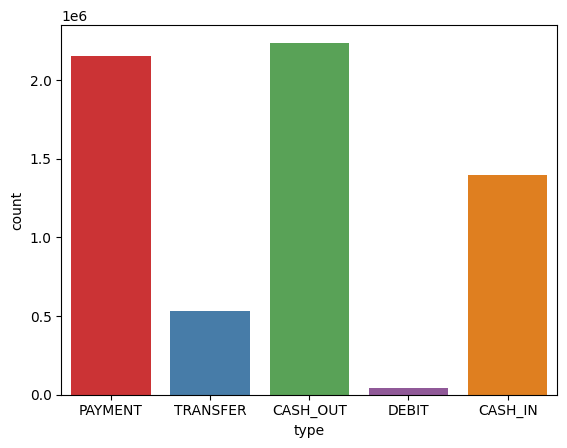

In [7]:
sns.countplot(x='type', data=data, hue='type', palette='Set1')

Many of the transactions that occur are either a payment, cash out, or cash in.

<Axes: xlabel='type', ylabel='amount'>

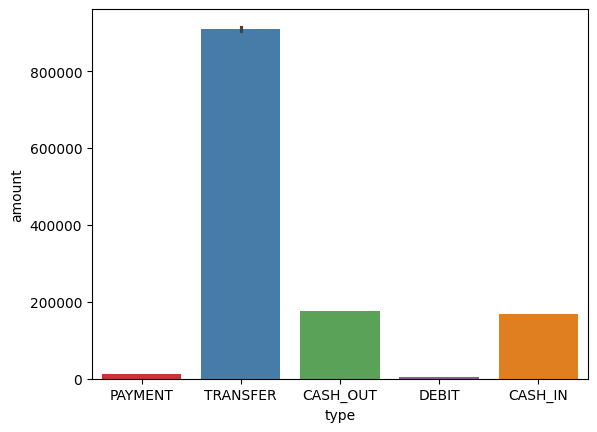

In [8]:
sns.barplot(x='type', y='amount', data=data, hue='type', palette='Set1')

Considering all types of transactions that occur, the majority of exchanged money occurs in transferring.

### Checking Data Quality

**Checking for Missing Values**

In [9]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

No missing/null values

**Checking Duplicate Values**

In [10]:
data.duplicated().sum()

np.int64(0)

No duplicated values

**Checking for Outliers**

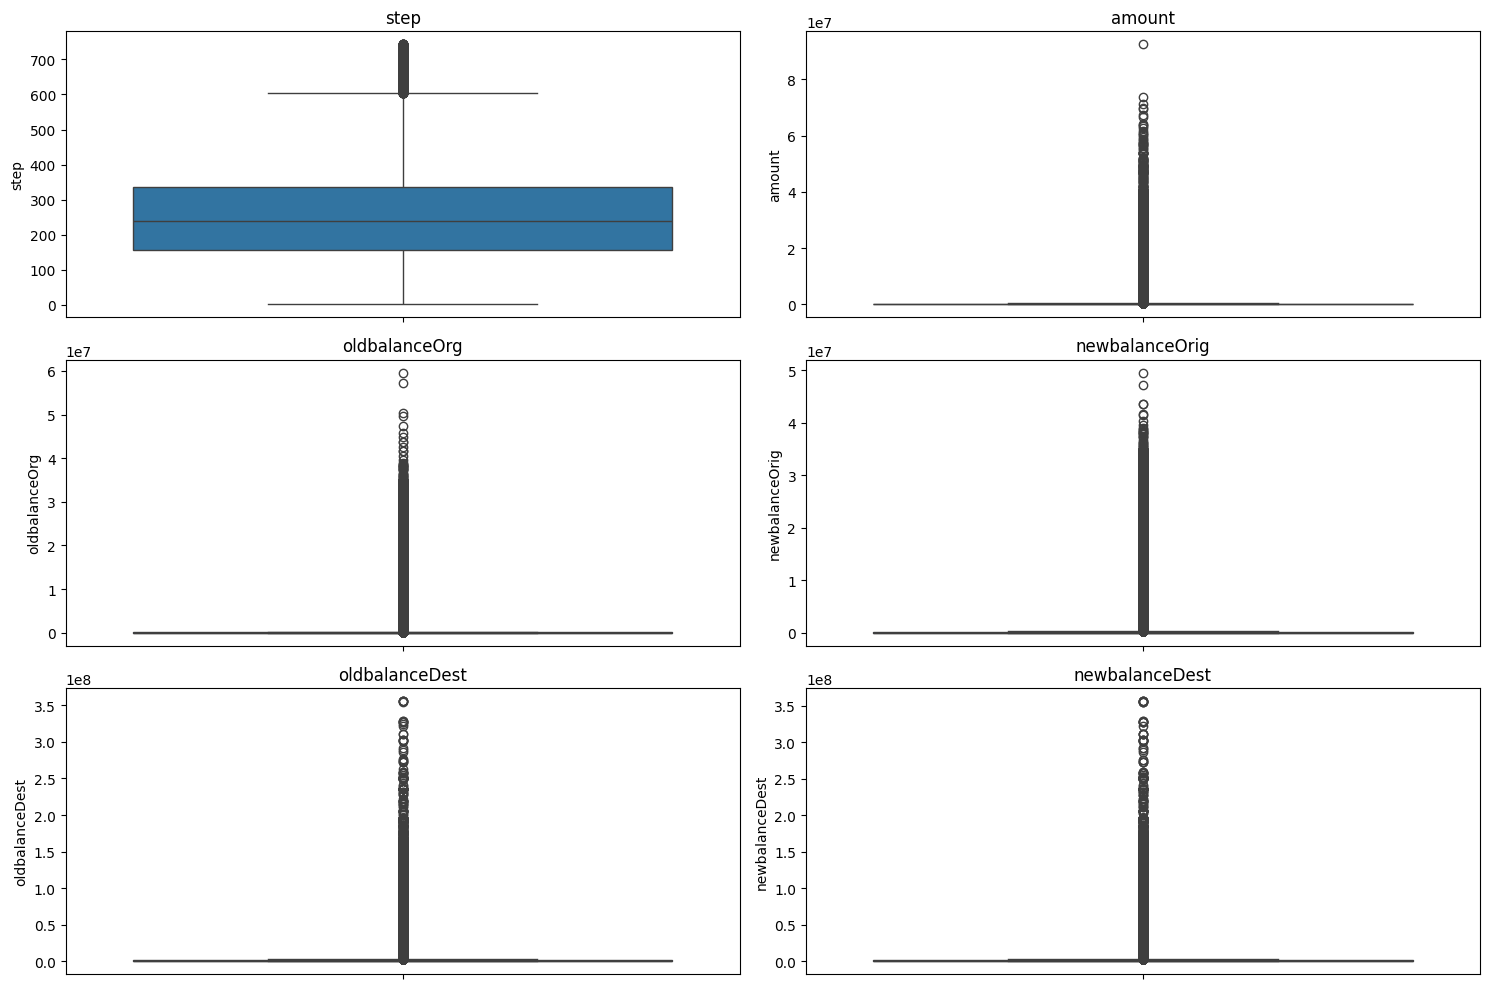

In [11]:
row = 0

plt.figure(figsize=(15, 10))

for index, col in enumerate(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']):
    plt.subplot(3, 2, index + 1)
    sns.boxplot(data[col])
    plt.title(col)

plt.tight_layout()
plt.show()

Looking at the graphs provided, we can visualize that there are a significant amount of entires that are beyond the max whisker. This signifys that there can be multiple different outliers; considering we are working with fradulant activity, it is important to know that many transactions have a wide range of money involved. As such, it is important to keep as all transactions regardless if the monetary amount is an outlier to the main summary stastics.

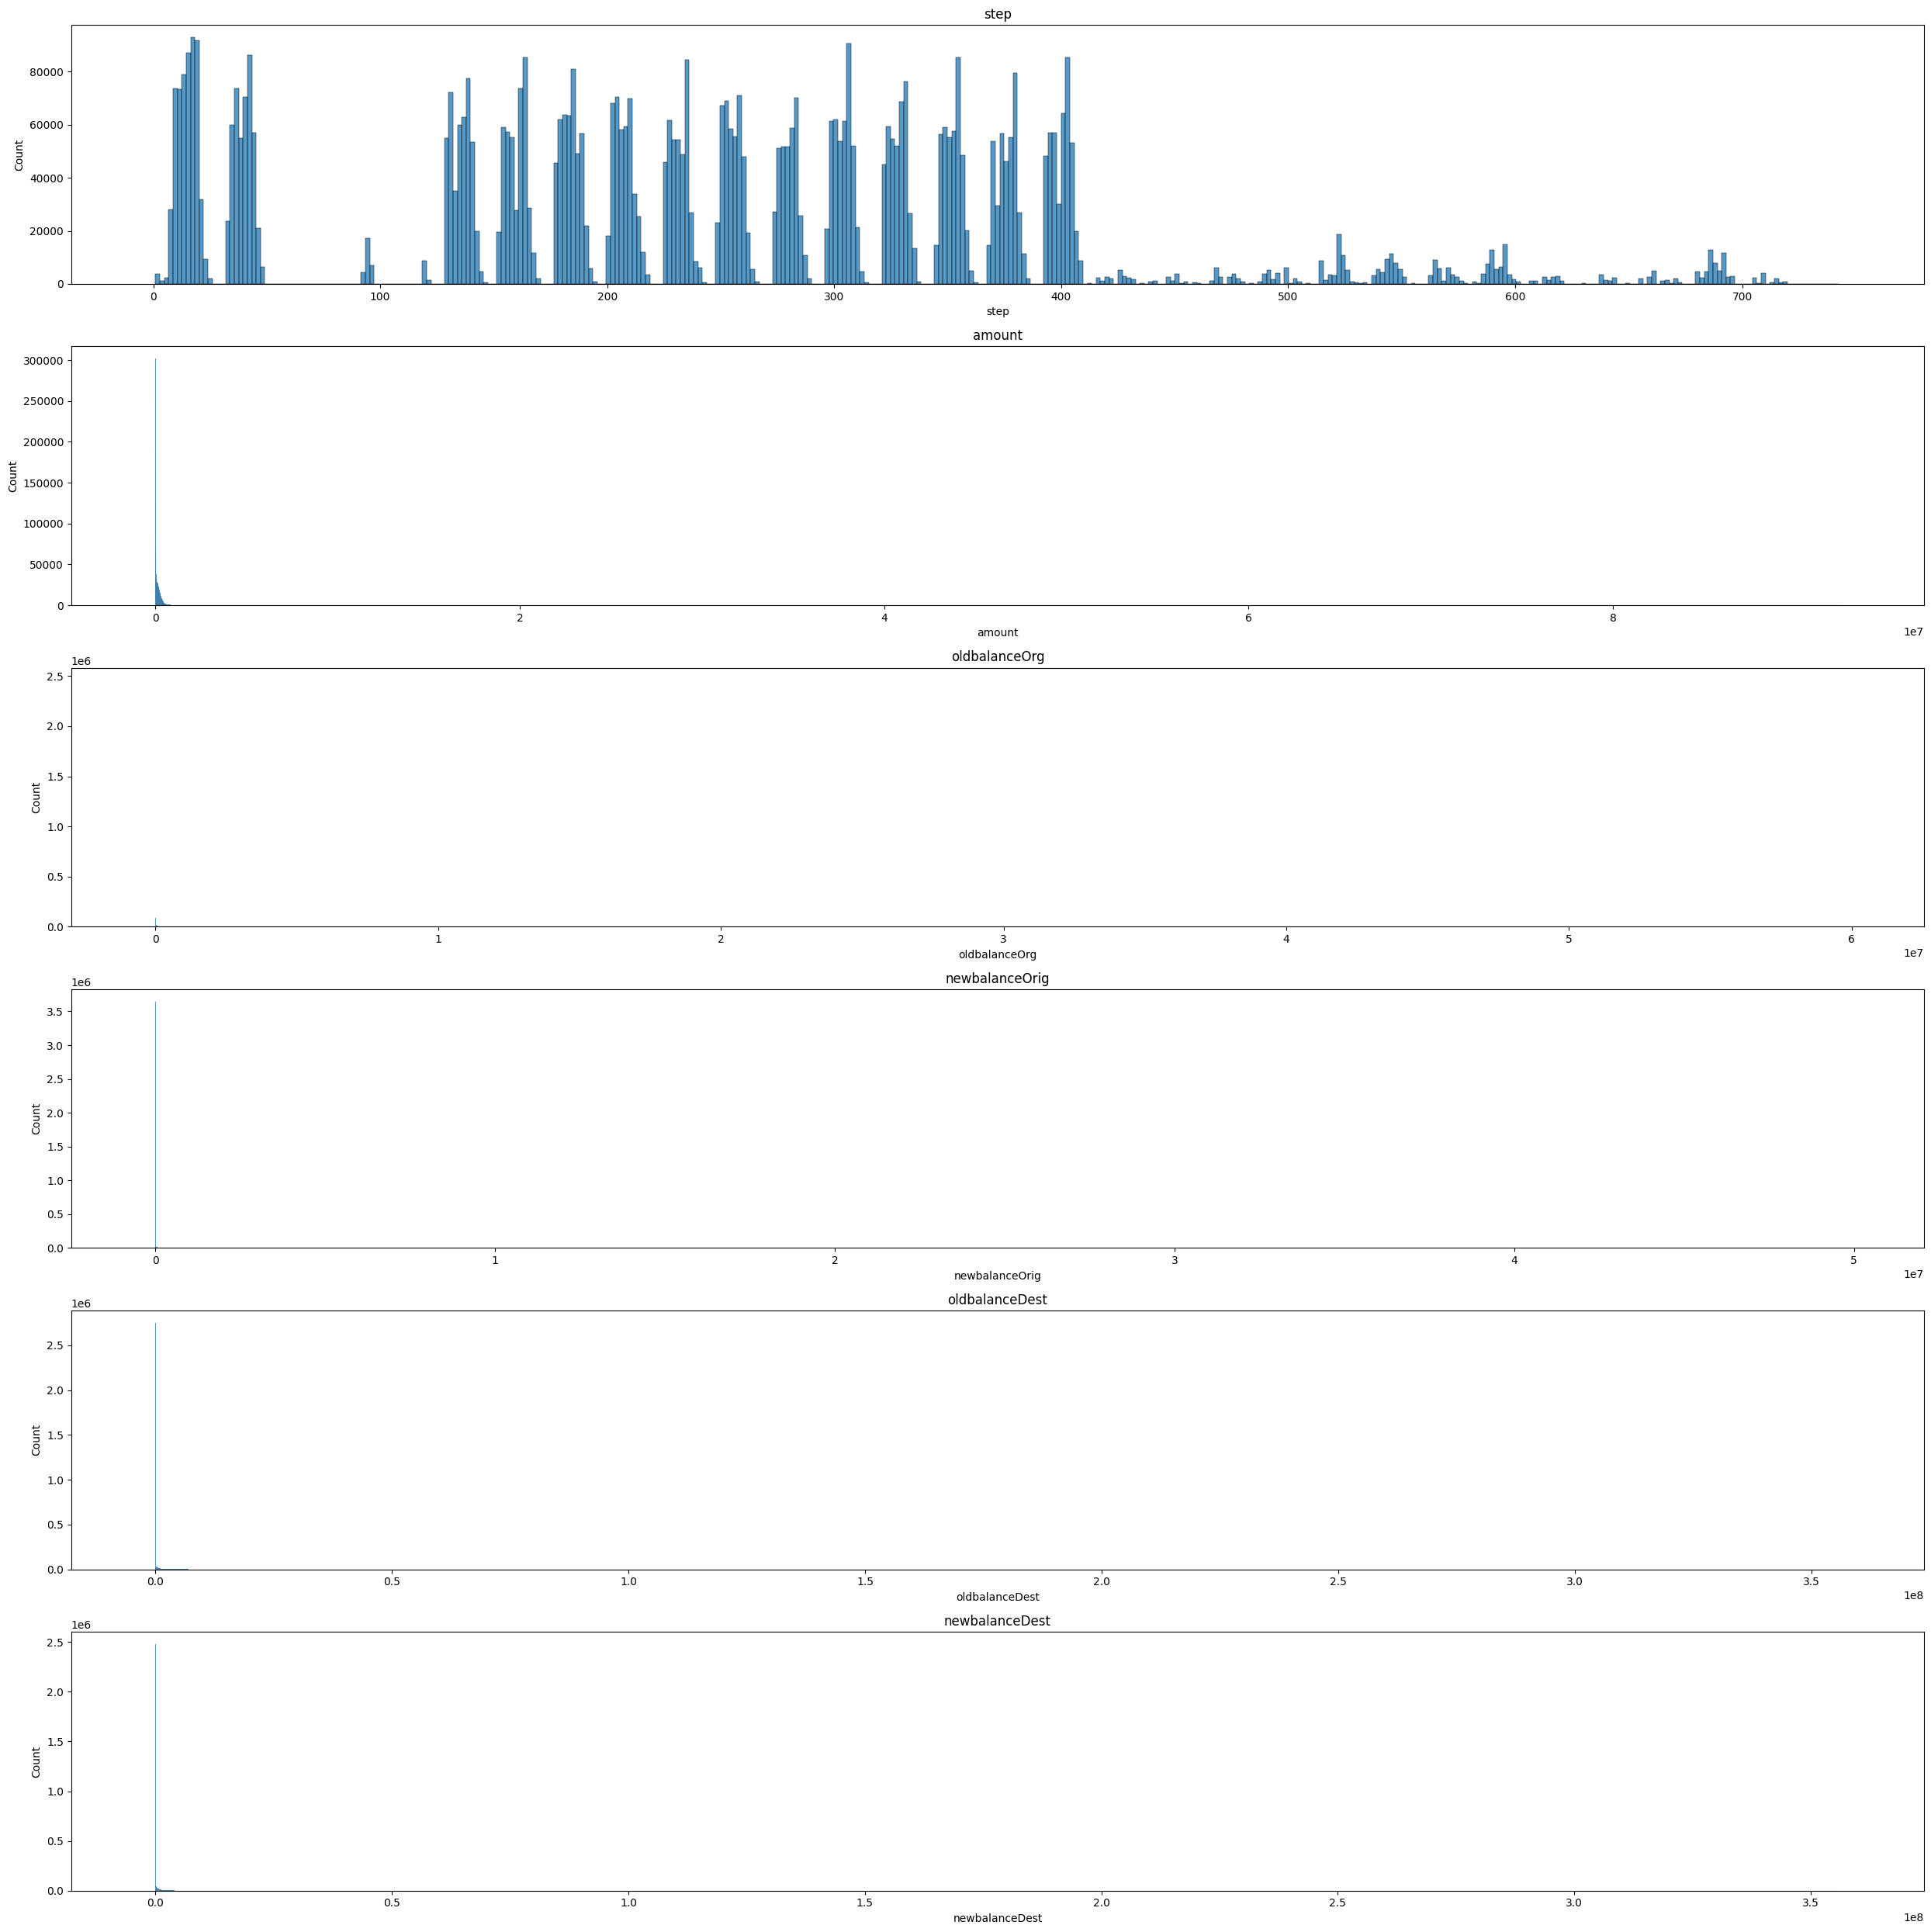

In [12]:
row = 0

plt.figure(figsize=(25, 25))

for index, col in enumerate(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']):
    plt.subplot(6, 1, index + 1)
    sns.histplot(data[col])
    plt.title(col)

plt.tight_layout()
plt.show()

*Scaling Features*<br>
Features to scale 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'.

Considering many models such as logistic regression suffer from not scaling, we will scale using MinMax Scaling. Additionally, we are testing with XGBoosting and Random Forest which scaling has minimal impact on.

In [13]:
for col in ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:
    print(col)
    data[col] = (data[col] - data[col].min()) / data[col].max()

amount
oldbalanceOrg
newbalanceOrig
oldbalanceDest
newbalanceDest


### Checking Class Distribution

In [14]:
data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

Considering this wide imbalance, we will be modifying this with SMOTE when creating the X_train variables

## Data Preprocessing

**Label Encoding**

*Encoding Type Variable*

In [15]:
type_new = pd.get_dummies(data['type'], drop_first=True) # encode the variable for each ot have their own feature
data_new = pd.concat([data, type_new], axis=1).drop(columns=['type'], axis = 1) # add & Drop old feature
data_new.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,0.000106,C1231006815,0.002855,0.003233,M1979787155,0.000000,0.0,0,0,False,False,True,False
1,1,0.000020,C1666544295,0.000357,0.000391,M2044282225,0.000000,0.0,0,0,False,False,True,False
2,1,0.000002,C1305486145,0.000003,0.000000,C553264065,0.000000,0.0,1,0,False,False,False,True
3,1,0.000002,C840083671,0.000003,0.000000,C38997010,0.000059,0.0,1,0,True,False,False,False
4,1,0.000126,C2048537720,0.000697,0.000603,M1230701703,0.000000,0.0,0,0,False,False,True,False


## Feature Engineering

**Dropping Unneeded Features**

In [16]:
data_new.drop(columns=['isFlaggedFraud', 'nameOrig', 'nameDest'], inplace=True)
data_new.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,0.000106,0.002855,0.003233,0.000000,0.0,0,False,False,True,False
1,1,0.000020,0.000357,0.000391,0.000000,0.0,0,False,False,True,False
2,1,0.000002,0.000003,0.000000,0.000000,0.0,1,False,False,False,True
3,1,0.000002,0.000003,0.000000,0.000059,0.0,1,True,False,False,False
4,1,0.000126,0.000697,0.000603,0.000000,0.0,0,False,False,True,False


We do not need the nameOrig and nameDest as fradulent activity happens on many different accounts and it would be impractical to create a feature for each account name. We also remove isFlaggedFraud as we only care about if it is fraud or not.

**Checking Correlation**

<Axes: >

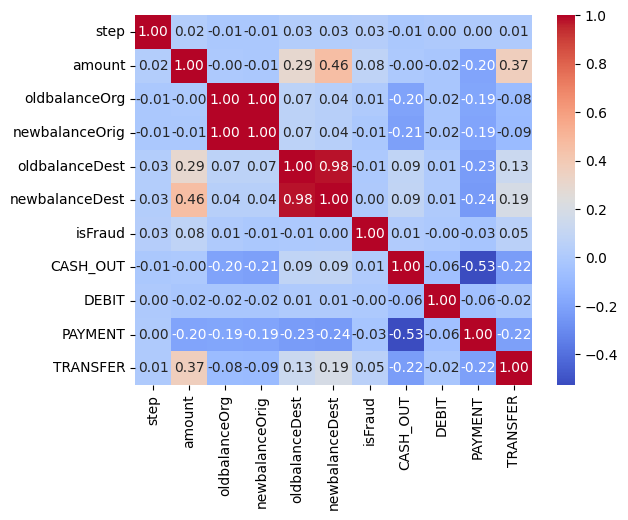

In [17]:
corr_matrix = data_new.corr()
sns.heatmap(data=corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')

Dropping features that relate to desitination and origin as we are looking to capture fraud itself not based on different accounts.

In [18]:
data.drop(columns=['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], inplace=True)

## Creating X & y Variables

In [19]:
X = data_new.drop(['isFraud'], axis=1)
y = data_new['isFraud']

In [20]:
X.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,0.000106,0.002855,0.003233,0.000000,0.0,False,False,True,False
1,1,0.000020,0.000357,0.000391,0.000000,0.0,False,False,True,False
2,1,0.000002,0.000003,0.000000,0.000000,0.0,False,False,False,True
3,1,0.000002,0.000003,0.000000,0.000059,0.0,True,False,False,False
4,1,0.000126,0.000697,0.000603,0.000000,0.0,False,False,True,False


In [21]:
X.drop(columns=['oldbalanceDest', 'newbalanceDest'], inplace=True)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [23]:
X_train.shape, y_train.shape # checking shape

((5090096, 8), (5090096,))

**Applying SMOTE for Class Imbalance**

In [24]:
sm = SMOTE(random_state=12)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

C:\Users\Savin\AppData\Local\Temp\ipykernel_26400\1167774258.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_train, y_train = sm.fit_resample(X_train, y_train.ravel())


In [25]:
X_train.shape, y_train.shape

((10167158, 8), (10167158,))

## Model Training

We are trying LogisticRegression, XGBClassifier, SVC, and RandomForest

In [26]:
models = [LogisticRegression(max_iter=500), 
		  XGBClassifier(),
		  RandomForestClassifier(n_estimators=7,
								criterion='entropy', 
								random_state=12)]

for i in range(len(models)):
	models[i].fit(X_train, y_train)
	print(f'{models[i]}')

	train_preds = models[i].predict_proba(X_train)[:, 1]
	print('Training Accuracy: ', ras(y_train, train_preds))
	
	y_preds = models[i].predict_proba(X_test)[:, 1]
	print('Validation Accuracy: ', ras(y_test, y_preds))
	print()


LogisticRegression(max_iter=500)
Training Accuracy:  0.9832039462635292
Validation Accuracy:  0.97949115627467

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Training Accuracy:  0.9998184560440999
Validation Accuracy:  0.9984122006516358

RandomForestClassifier(criterion='entropy', n_est

## Model Evauation

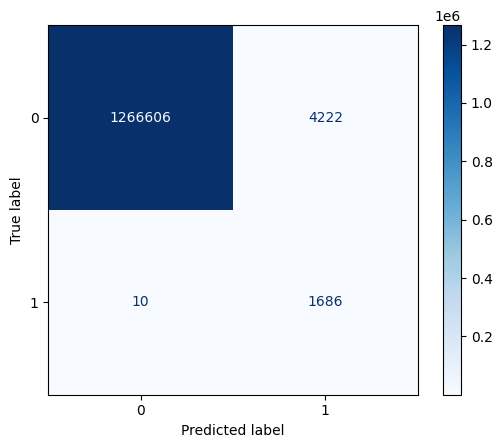

In [27]:
y_pred = models[1].predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=models[1].classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')

plt.show()

In [28]:
print('The model reached a recall of {:.2f}%.'.format(recall_score(y_test, y_pred) * 100))

The model reached a recall of 99.41%.


## Results and Conclusion

This project aimed to develop a fraud detection model capable of accurately identifying fradulent transactions. Given the nature of fraudelent activity, the primary focus was on maximizing recall which the model achieved a score of 99% on signifying that it performed above expectations other models and was able to accurately catch necessary transactions. 